In [1]:
import math
import time
import numpy as np
import bifrost as bf
from bifrost.fdmt import Fdmt
import cupy
import matplotlib.pyplot as plt

/mnt_home/mhawkins/bifrost/python/bifrost/ring2.py:47: RuntimeWarning: Install simplejson for better performance
  warnings.warn("Install simplejson for better performance", RuntimeWarning)
/mnt_home/mhawkins/bifrost/python/bifrost/blocks/serialize.py:40: RuntimeWarning: Install simplejson for better performance
  warnings.warn("Install simplejson for better performance", RuntimeWarning)


In [2]:
def run_test(pulse, f_max, f_min, dt, max_dm, exponent, n_iters, batch_shape=()):
    # Make null stream to force synching of all other streams (IDK what FDMT Bifrost is actually doing to launch the kernels)
    # cu_stream = cupy.cuda.Stream(null=True)
    # cu_stream.use()

    (nchan, ntime) = (4096, 3000) # pulse.shape

    bw        = f_max - f_min
    df        = bw / nchan

    # Calculate max delay from max dm
    rel_delay = (4.148741601e3 / dt * max_dm * (f_min**-2 - (f_min + nchan * df)**-2))
    max_delay = int(math.ceil(abs(rel_delay)))

    fdmt = Fdmt()
    print(f"nchan: {nchan}  Max Delay: {max_delay}  f0: {f_min}  df: {df}  exponent: {exponent} f_max: {f_min + nchan * df}")

    fdmt.init(nchan, max_delay, f_min, df, exponent, 'cuda')

    ishape = batch_shape + (nchan, ntime)
    print(ishape)
    oshape = batch_shape + (max_delay, ntime)

    # Random input
    in_data = bf.asarray(pulse, space='cuda')
    # Pre-allocate output
    out_data = bf.asarray(-999 * np.ones(oshape, np.float32),
                        space='cuda')

    # Warmup
    fdmt.execute(in_data, out_data)

    times = np.empty(n_iters, dtype=float)

    # for i in range(n_iters):
    #     tic = time.perf_counter()
    #     fdmt.execute(in_data, out_data)
    #     cu_stream.synchronize()
    #     toc = time.perf_counter()
    #     times[i] = toc - tic

    out_data = out_data.copy('system')

    if max_delay > 1:
        min = out_data.min()
        if min != -999:
            print("Error in output data minimum value!\n")
            exit()
    # TODO: Need better tests
    max = out_data.max()
    if max >= 100.:
        print("Error in odata maximum\n")
        exit()
    return (times, out_data)

In [3]:
pulse = np.load("../dispersed_pulse.npz")
pulse_trans = np.transpose(pulse)

n_iters = 1
f_max   = 1500.0
f_min   = 1200.0
t_samp  = 1e-3
dm_min  = 0.0
dm_max  = 2000.0

pulse.shape, pulse.flags, pulse.__array_interface__, pulse_trans.flags, pulse_trans.__array_interface__, pulse_trans.shape

((3000, 4096),
   C_CONTIGUOUS : False
   F_CONTIGUOUS : True
   OWNDATA : False
   WRITEABLE : True
   ALIGNED : True
   WRITEBACKIFCOPY : False
   UPDATEIFCOPY : False,
 {'data': (140033062850576, False),
  'strides': (4, 12000),
  'descr': [('', '<f4')],
  'typestr': '<f4',
  'shape': (3000, 4096),
  'version': 3},
   C_CONTIGUOUS : True
   F_CONTIGUOUS : False
   OWNDATA : False
   WRITEABLE : True
   ALIGNED : True
   WRITEBACKIFCOPY : False
   UPDATEIFCOPY : False,
 {'data': (140033062850576, False),
  'strides': None,
  'descr': [('', '<f4')],
  'typestr': '<f4',
  'shape': (4096, 3000),
  'version': 3},
 (4096, 3000))

In [4]:
(times, out_data) = run_test(pulse_trans,
                            f_max=f_max,
                            f_min=f_min,
                            dt=t_samp,
                            max_dm=dm_max,
                            exponent=-2.0,
                            n_iters=n_iters)

nchan: 4096  Max Delay: 2075  f0: 1200.0  df: 0.0732421875  exponent: -2.0 f_max: 1500.0
(4096, 3000)
Error in odata maximum



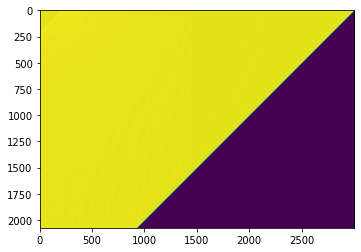

In [5]:
plt.imshow(out_data)

In [11]:
out_data.min(), out_data.max()

(ndarray(-999., dtype=float32), ndarray(2185.991, dtype=float32))

In [171]:
 (npol, nchan, ntime) = pulse.shape

bw        = f_max - f_min
df        = bw / nchan

# Calculate max delay from max dm
rel_delay = (4.148741601e3 / t_samp * dm_max * (f_max**-2 - (f_max + nchan * df)**-2))
max_delay = int(math.ceil(abs(rel_delay)))

fdmt = Fdmt()
fdmt.init(nchan, max_delay, f_min, df, -2.0, 'cuda')

ValueError: not enough values to unpack (expected 3, got 2)

In [172]:
bf.libbifrost_generated.BF_CUDA_ENABLED

1

In [173]:
times, out_data.shape

(array([nan]), (2075, 4096))

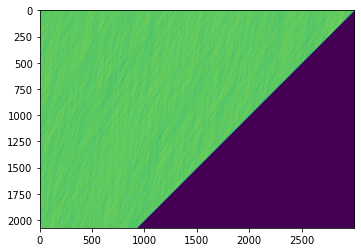

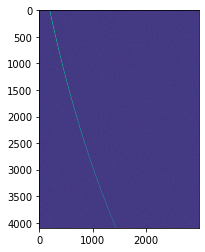

In [144]:
plt.imshow(pulse[0,:,:])

In [183]:
pulse_fortran = np.asfortranarray(pulse).copy()

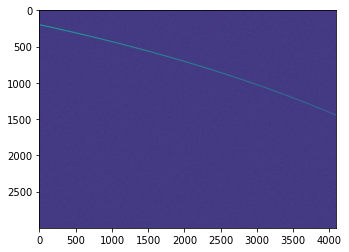

In [184]:
plt.imshow(pulse_fortran)

In [185]:
(times, out_data_fortran) = run_test(pulse_fortran,
                            f_max=f_max,
                            f_min=f_min,
                            dt=t_samp,
                            max_dm=dm_max,
                            exponent=-2.0,
                            n_iters=n_iters)

nchan: 3000  Max Delay: 2075  f0: 1200.0  df: 0.1  exponent: -2.0 f_max: 1500.0


In [186]:
pulse_fortran.shape

(3000, 4096)

In [187]:
pulse.shape

(3000, 4096)

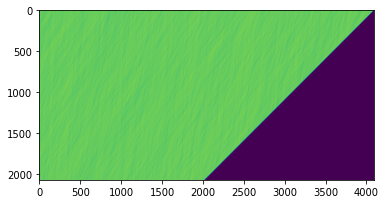

In [188]:
plt.imshow(out_data_fortran)

In [192]:
pulse.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [193]:
pulse_fortran.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False